In [1]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
from keras import backend as K 
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
import json
import gzip
import codecs
import os
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [2]:
!head data/experimental/GR_pseudorandom_CTerm_120106_out.csv

,OligoSeq,ddG,rN,rNN,Ratio
101,AGTACGCCATGCAGCCTTGCCATAGCGGGCTATACGGCAGCCGTGACTAGTT,5.212192307268088,0.0154781119153,0.00613283600575,0.0346208869814
102,GGAACGCAATCGCCGACTATTGTTGATCCACAGTCTGGTACACCGGGTCCAG,3.603454709147569,0.290756214833,0.11520527781300001,0.309898989899
118,ACATCATTTATTGAGTTTCGAGGGCATCGTACAGAGTATCTTTATCTATATG,3.966985890131547,0.0400524361078,0.0158698311283,0.0591952111739
120,ATGATGACAATACATACATGCAGAGTTTTCAGACGAGCAGTTCCTATTGCGG,3.129535994795905,0.106149053728,0.0420590536004,0.125291828794
128,GGAGTAGCAAGCCATGTTCCACCCGCCGCTTCACATCAAAACACTCCAAACC,4.713621825584096,0.03666645882530001,0.014528217661099999,0.05580923389140001
129,ACGGGGTTTCAATGTGAAATCCCTCCATTCCCCTACATCGGCTACACACAAT,5.226609374331665,0.0173365462488,0.00686919668447,0.036479321315
130,GGTAACATGCCTACTAGTACTACGGCCGTACGGGCATAAACTTTAACATTGC,4.243569702635406,0.0954272683123,0.0378107995497,0.114570043378
132,CTATATGACCTATACCCGTTCCTGCCGGGGAGGAGCCGTCGAACATAGGCGC,4.566013555661497,0.0482124112832,0.019103

In [3]:
!head data/experimental/GR_pseudorandom_Dex_120125_out.csv

,OligoSeq,ddG,rN,rNN,Ratio
2,AAGATATCCCCTTACACGGTAATCATATCGGGCGAATATTGTGTTGTTGCCA,5.130512506859378,0.010947689245599999,0.004719892893520001,0.0122377622378
3,TACAAGAGACGAATCTGGACCGCCCGTTAAGGGTTATCAGCAGTCATTTGCC,5.792132845018782,0.00551809681163,0.0023790249561,0.006808169803760001
4,CGCTGAGTAACGGACCGGACAAAGAGCGGCCTTCCTGGACTCACTGTTTAAC,4.282099589830911,0.0667916250455,0.0287959686584,0.0680816980376
6,TAAACTAACGTCACCAGTCCGTTTTTGGGAGAAGCCAGCGTTGATACCACAA,5.669151127612541,0.00681918863826,0.00293996653277,0.00810926163039
7,ATGGACAACGTGTGGAGTGCGAACCCCATACCATAGTGACCCCGACTGAGGT,4.950425116276885,0.007366306383100001,0.00317584618717,0.00865637937524
13,GTTGATTGCGGATTTGACAGCGCGCCCTCGTCGTGGGCCGTTTGATCCGATG,5.359278263561248,0.00819268562856,0.00353212425102,0.00948275862069
22,CGTGAGGCCTTTATGTGATTATTTTTCTAATGTCGTTGCCTGATGTACCCTG,3.8958802249204925,0.10959702378200001,0.047250721325199994,0.11088709677400001
29,TTGCAGGACAATGGAAGTGTATAACAAGCTAGCCGTATCATACTCCCTGTAT,4.422975509424104,0.04907

In [4]:
!head data/experimental/GR_pseudorandom_NTerm_120106_out.csv

,OligoSeq,ddG,rN,rNN,Ratio
0,GCAATTGCAATGCAAAAAACGTAGCGCAGGTGTGAGTACCCTCGTACGGTTA,3.349207255765878,0.020035713839599997,0.00787662533297,0.027999999999999997
2,AAGATATCCCCTTACACGGTAATCATATCGGGCGAATATTGTGTTGTTGCCA,3.0380699986301116,0.051903591626500004,0.020404820509500002,0.059867877787
3,TACAAGAGACGAATCTGGACCGCCCGTTAAGGGTTATCAGCAGTCATTTGCC,2.537690447188862,0.142471760351,0.05600981755869999,0.15043604651200002
4,CGCTGAGTAACGGACCGGACAAAGAGCGGCCTTCCTGGACTCACTGTTTAAC,2.444421345247052,0.15984100846,0.0628381771949,0.16780529462000002
6,TAAACTAACGTCACCAGTCCGTTTTTGGGAGAAGCCAGCGTTGATACCACAA,2.7494043770714063,0.0851889509146,0.0334902691381,0.09315323707499999
8,CGACCGCCGGTCAGCTCGGCCTCCGCAACCCAGTCGGAGACCCAGCGTGAGG,2.7915787483345467,0.0630693165618,0.024794393678299997,0.0710336027222
17,ATTTGCCTCATTCAAAAGGGTAAGGAGTGGAAACGGTAGAGCGGATAACCGT,3.233730903647772,0.035119614066400004,0.013806547850200001,0.043083900226800004
19,GGCAGCTAAACTGGGTACAATAATCTCTTGAATGTCACTACGTCCAGTAGAT,2.83087709209

197


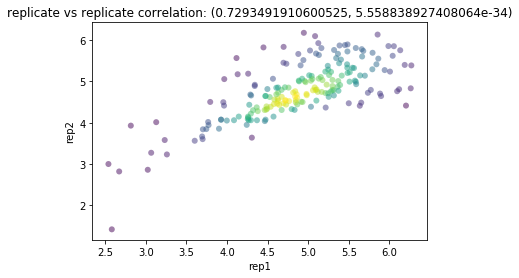

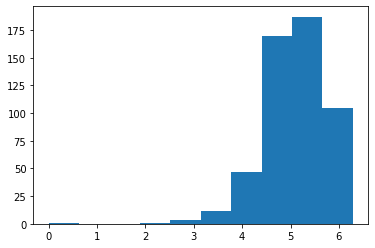

In [5]:
seqToDdg = {}
seqToRN = {}
seqToRNN = {}
seqToRatio = {}

firstLine = True
with open("data/experimental/GR_pseudorandom_CTerm_120106_out.csv") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        idx,Sequence,ddG,rN,rNN,ratio = line.strip().split(',')
        seq = Sequence.upper()
        if seq not in seqToDdg:
            seqToDdg[seq] = []
            seqToRN[seq] = []
            seqToRNN[seq] = []
            seqToRatio[seq] = []
        seqToDdg[seq].append(float(ddG))
        seqToRN[seq].append(float(rN))
        seqToRNN[seq].append(float(rNN))
        seqToRatio[seq].append(float(ratio))

rep1 = []
rep2 = []
count = 0
cterm = {}
for seq in seqToDdg.keys():
    val = seqToDdg[seq]
    if len(val) > 1:
        rep1.append(val[0])
        rep2.append(val[1])
        count += 1
    cterm[seq] = np.mean(val)
print(count)
xy = np.vstack([rep1,rep2])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(rep1, rep2, c=z, edgecolor='', alpha=0.5)
plt.xlabel("rep1")
plt.ylabel("rep2")
plt.title("replicate vs replicate correlation: "+str(pearsonr(rep1, rep2)))
plt.show()

plt.hist(cterm.values())
plt.show()

128


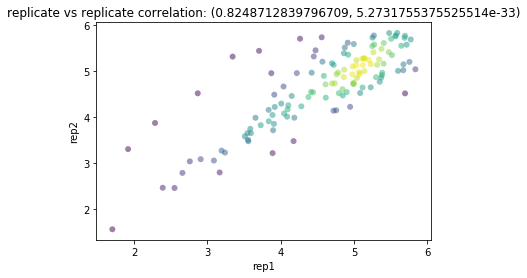

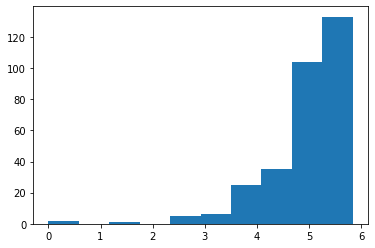

In [6]:
seqToDdg = {}
seqToRN = {}
seqToRNN = {}
seqToRatio = {}

firstLine = True
with open("data/experimental/GR_pseudorandom_Dex_120125_out.csv") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        idx,Sequence,ddG,rN,rNN,ratio = line.strip().split(',')
        seq = Sequence.upper()
        if seq not in seqToDdg:
            seqToDdg[seq] = []
            seqToRN[seq] = []
            seqToRNN[seq] = []
            seqToRatio[seq] = []
        seqToDdg[seq].append(float(ddG))
        seqToRN[seq].append(float(rN))
        seqToRNN[seq].append(float(rNN))
        seqToRatio[seq].append(float(ratio))

rep1 = []
rep2 = []
count = 0
dex = {}
for seq in seqToDdg.keys():
    val = seqToDdg[seq]
    if len(val) > 1:
        rep1.append(val[0])
        rep2.append(val[1])
        count += 1
    dex[seq] = np.mean(val)
print(count)
xy = np.vstack([rep1,rep2])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(rep1, rep2, c=z, edgecolor='', alpha=0.5)
plt.xlabel("rep1")
plt.ylabel("rep2")
plt.title("replicate vs replicate correlation: "+str(pearsonr(rep1, rep2)))
plt.show()

plt.hist(dex.values())
plt.show()

171


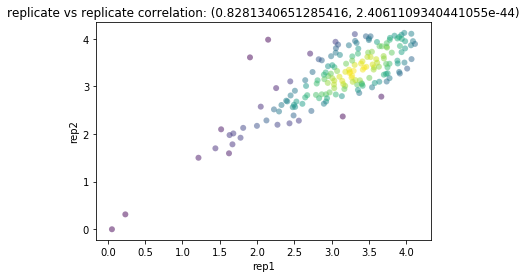

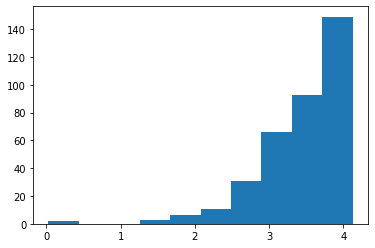

In [7]:
seqToDdg = {}
seqToRN = {}
seqToRNN = {}
seqToRatio = {}

firstLine = True
with open("data/experimental/GR_pseudorandom_NTerm_120106_out.csv") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        idx,Sequence,ddG,rN,rNN,ratio = line.strip().split(',')
        seq = Sequence.upper()
        if seq not in seqToDdg:
            seqToDdg[seq] = []
            seqToRN[seq] = []
            seqToRNN[seq] = []
            seqToRatio[seq] = []
        seqToDdg[seq].append(float(ddG))
        seqToRN[seq].append(float(rN))
        seqToRNN[seq].append(float(rNN))
        seqToRatio[seq].append(float(ratio))

rep1 = []
rep2 = []
count = 0
nterm = {}
for seq in seqToDdg.keys():
    val = seqToDdg[seq]
    if len(val) > 1:
        rep1.append(val[0])
        rep2.append(val[1])
        count += 1
    nterm[seq] = np.mean(val)
print(count)
xy = np.vstack([rep1,rep2])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(rep1, rep2, c=z, edgecolor='', alpha=0.5)
plt.xlabel("rep1")
plt.ylabel("rep2")
plt.title("replicate vs replicate correlation: "+str(pearsonr(rep1, rep2)))
plt.show()

plt.hist(nterm.values())
plt.show()

309


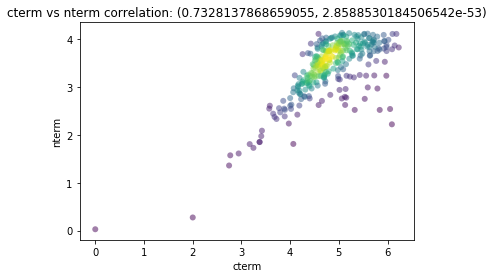

In [8]:
#cterm vs nterm
rep1 = []
rep2 = []
count = 0
for seq in cterm.keys():
    if seq in nterm:
        rep1.append(cterm[seq])
        rep2.append(nterm[seq])
        count += 1
print(count)
xy = np.vstack([rep1,rep2])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(rep1, rep2, c=z, edgecolor='', alpha=0.5)
plt.xlabel("cterm")
plt.ylabel("nterm")
plt.title("cterm vs nterm correlation: "+str(pearsonr(rep1, rep2)))
plt.show()

265


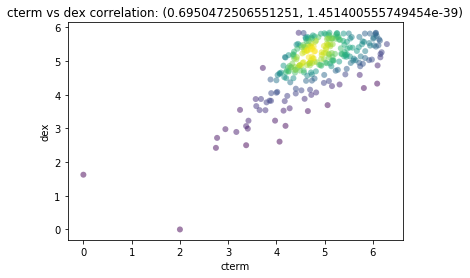

In [9]:
#cterm vs dex
rep1 = []
rep2 = []
count = 0
for seq in cterm.keys():
    if seq in dex:
        rep1.append(cterm[seq])
        rep2.append(dex[seq])
        count += 1
print(count)
xy = np.vstack([rep1,rep2])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(rep1, rep2, c=z, edgecolor='', alpha=0.5)
plt.xlabel("cterm")
plt.ylabel("dex")
plt.title("cterm vs dex correlation: "+str(pearsonr(rep1, rep2)))
plt.show()

218


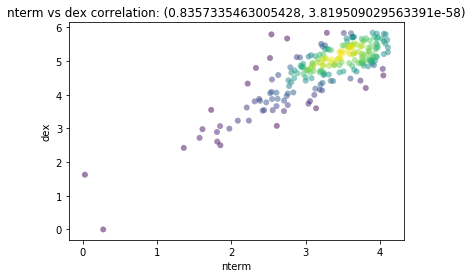

In [10]:
#nterm vs dex
rep1 = []
rep2 = []
count = 0
for seq in dex.keys():
    if seq in nterm:
        rep1.append(nterm[seq])
        rep2.append(dex[seq])
        count += 1
print(count)
xy = np.vstack([rep1,rep2])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(rep1, rep2, c=z, edgecolor='', alpha=0.5)
plt.xlabel("nterm")
plt.ylabel("dex")
plt.title("nterm vs dex correlation: "+str(pearsonr(rep1, rep2)))
plt.show()